In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin

import joblib

DATA_PROCESSED = "processed_data"
os.makedirs(DATA_PROCESSED, exist_ok=True)

**Load Dataset**

In [ ]:
df = pd.read_csv("heart_disease.csv")
print("Initial dataset shape:", df.shape)
display(df.head())

Initial dataset shape: (10004, 21)


,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,...,High LDL Cholesterol,Alcohol Consumption,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level,Heart Disease Status
0,56.0,Male,153.0,155.0,High,Yes,Yes,No,24.991591,Yes,...,No,High,Medium,7.633228,Medium,342.0,NaN,12.969246,12.387250,No
1,69.0,Female,146.0,286.0,High,No,Yes,Yes,25.221799,No,...,No,Medium,High,8.744034,Medium,133.0,157.0,9.355389,19.298875,No
2,46.0,Male,126.0,216.0,Low,No,No,No,29.855447,No,...,Yes,Low,Low,4.440440,Low,393.0,92.0,12.709873,11.230926,No
3,32.0,Female,122.0,293.0,High,Yes,Yes,No,24.130477,Yes,...,Yes,Low,High,5.249405,High,293.0,94.0,12.509046,5.961958,No
4,60.0,Male,166.0,242.0,Low,Yes,Yes,Yes,20.486289,Yes,...,No,Low,High,7.030971,High,263.0,154.0,10.381259,8.153887,No


**Convert blank, text-based missing values to NaN**

In [ ]:
df = df.replace(r'^\s*$', np.nan, regex=True)
df = df.replace(["", " ", "nan", "NaN", "NONE", "None"], np.nan)

In [ ]:
X = df.drop("Heart Disease Status", axis=1)
y = df["Heart Disease Status"]

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# **Handling Missing Values**

Missing values in each column:
 Age                       29
Gender                    19
Blood Pressure            19
Cholesterol Level         30
Exercise Habits           25
Smoking                   25
Family Heart Disease      21
Diabetes                  30
BMI                       21
High Blood Pressure       26
Low HDL Cholesterol       25
High LDL Cholesterol      26
Alcohol Consumption     2588
Stress Level              22
Sleep Hours               25
Sugar Consumption         30
Triglyceride Level        26
Fasting Blood Sugar       21
CRP Level                 26
Homocysteine Level        20
Heart Disease Status       0
dtype: int64

Total missing values in dataset: 3054


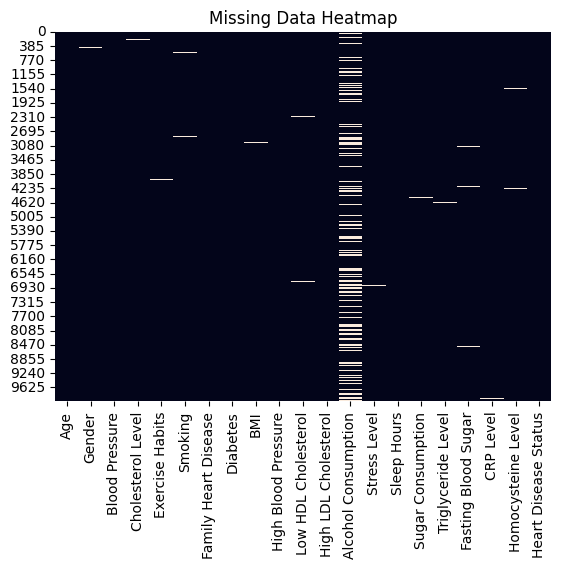

In [ ]:
# Identify Missing Values
missing = df.isna().sum()
print("Missing values in each column:\n", missing)

total_missing = df.isna().sum().sum()
print(f"\nTotal missing values in dataset: {total_missing}")

sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Data Heatmap")
plt.show()


Missing values handled. Shape after cleaning: (10004, 21)


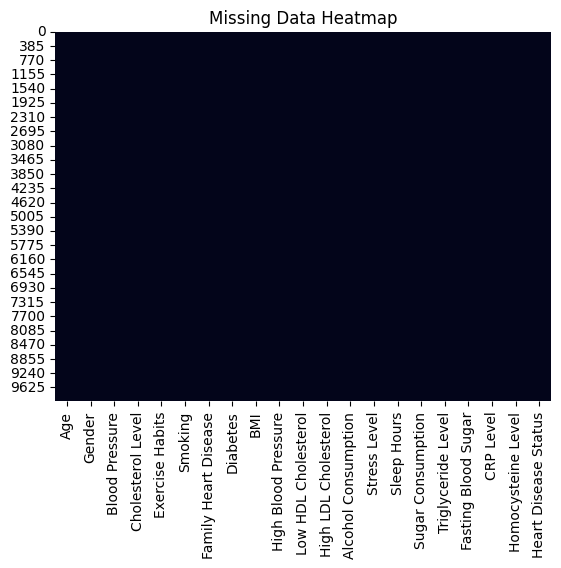

In [ ]:
# Fill missing numerical values with median
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Fill missing categorical values with mode
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("\nMissing values handled. Shape after cleaning:", df.shape)

sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Data Heatmap")
plt.show()

In [ ]:
print("Ordinal Columns and Their Unique Values:\n")
for col in categorical_cols:
    print(col, "-->", X[col].unique())
    print("Ordinal Columns and Their Unique Values:\n")


Ordinal Columns and Their Unique Values:

Gender --> ['Male' 'Female' nan]
Ordinal Columns and Their Unique Values:

Exercise Habits --> ['High' 'Low' 'Medium' nan]
Ordinal Columns and Their Unique Values:

Smoking --> ['Yes' 'No' nan]
Ordinal Columns and Their Unique Values:

Family Heart Disease --> ['Yes' 'No' nan]
Ordinal Columns and Their Unique Values:

Diabetes --> ['No' 'Yes' nan]
Ordinal Columns and Their Unique Values:

High Blood Pressure --> ['Yes' 'No' nan]
Ordinal Columns and Their Unique Values:

Low HDL Cholesterol --> ['Yes' 'No' nan]
Ordinal Columns and Their Unique Values:

High LDL Cholesterol --> ['No' 'Yes' nan]
Ordinal Columns and Their Unique Values:

Alcohol Consumption --> ['High' 'Medium' 'Low' nan]
Ordinal Columns and Their Unique Values:

Stress Level --> ['Medium' 'High' 'Low' nan]
Ordinal Columns and Their Unique Values:

Sugar Consumption --> ['Medium' 'Low' 'High' nan]
Ordinal Columns and Their Unique Values:



In [ ]:
X = df.drop("Heart Disease Status", axis=1)  # Features
y = df["Heart Disease Status"]               # Target

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# ***Outliers Handling***

In [ ]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_clean = X.copy()
        if self.columns:
            for col in self.columns:
                Q1 = X_clean[col].quantile(0.25)
                Q3 = X_clean[col].quantile(0.75)
                IQR = Q3 - Q1
                lower = Q1 - 1.5*IQR
                upper = Q3 + 1.5*IQR
                X_clean = X_clean[(X_clean[col] >= lower) & (X_clean[col] <= upper)]
        return X_clean.reset_index(drop=True)

Age: 2 outliers detected


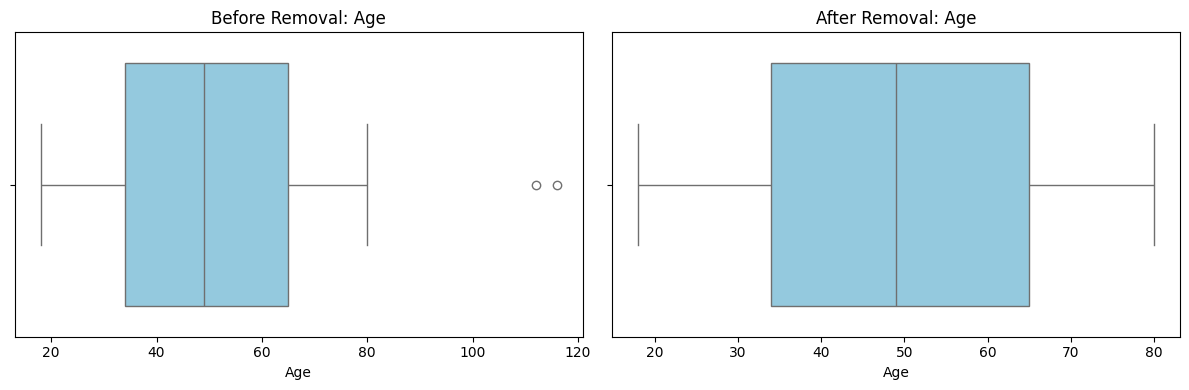

Blood Pressure: 0 outliers detected


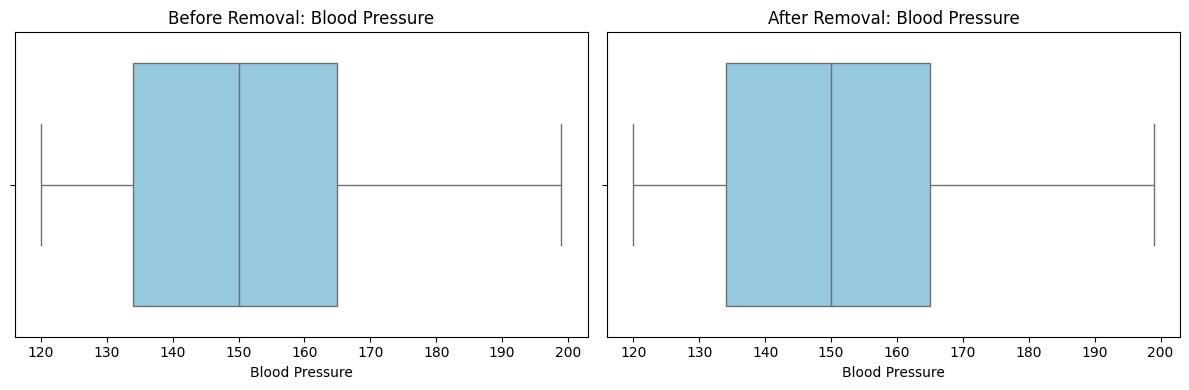

Cholesterol Level: 0 outliers detected


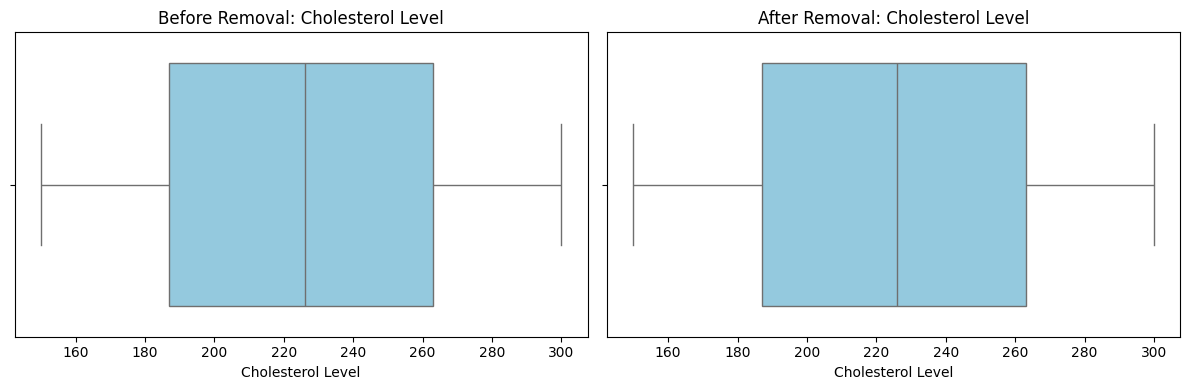

BMI: 1 outliers detected


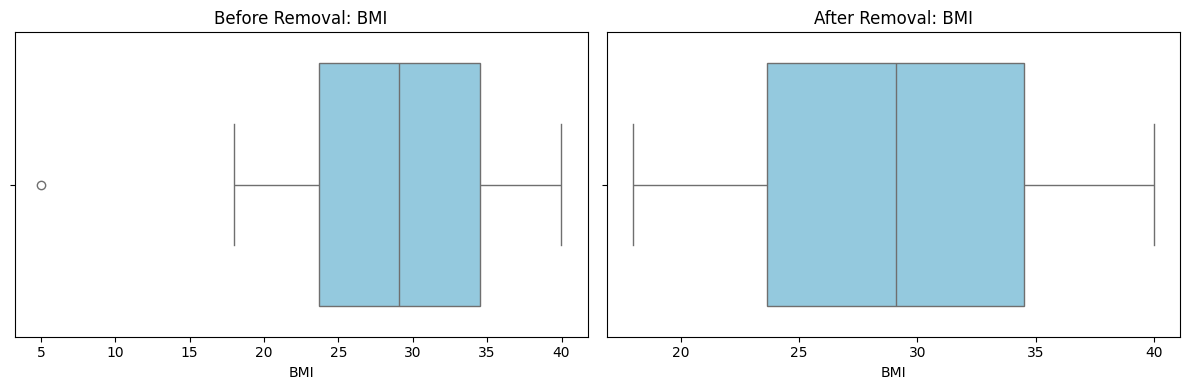

Sleep Hours: 0 outliers detected


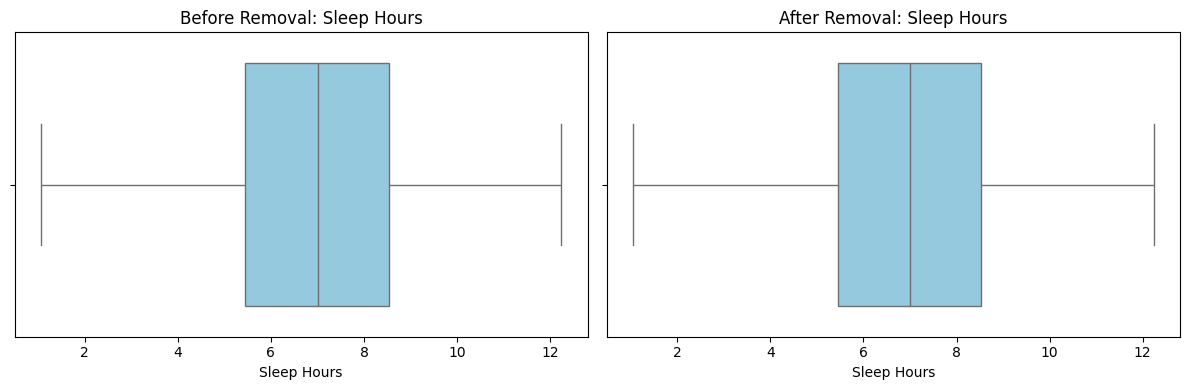

Triglyceride Level: 0 outliers detected


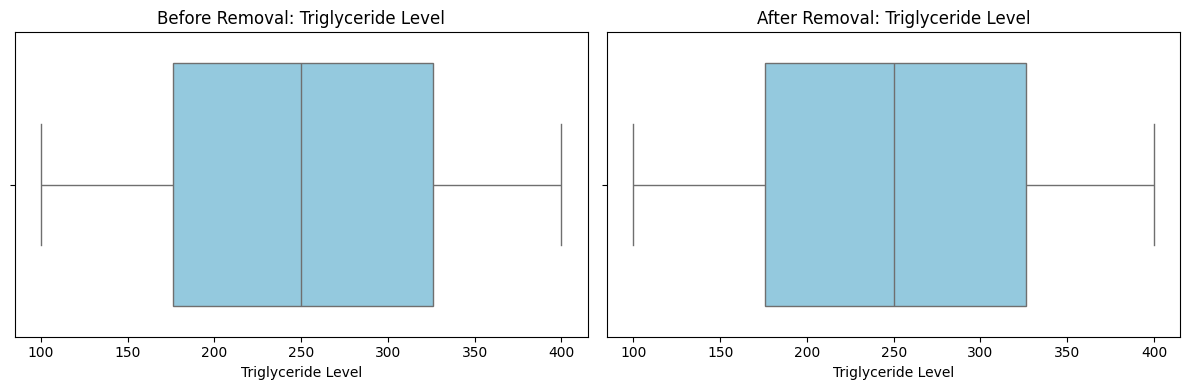

Fasting Blood Sugar: 1 outliers detected


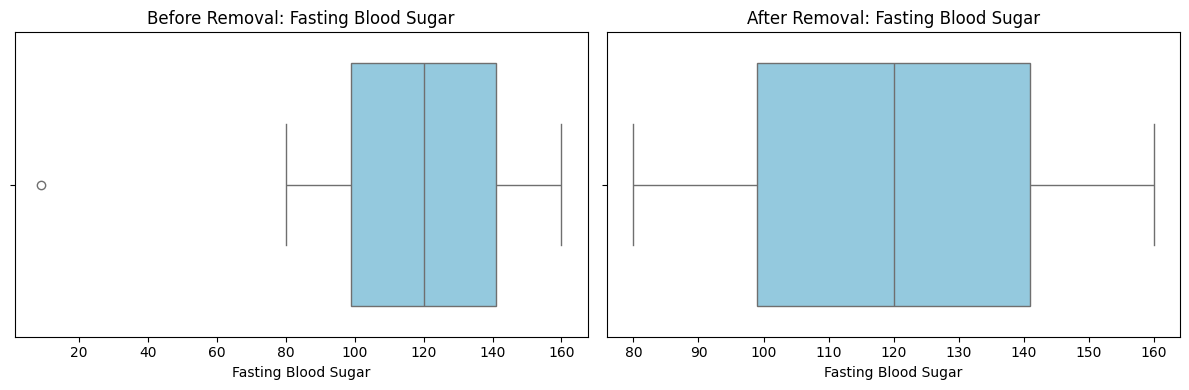

CRP Level: 0 outliers detected


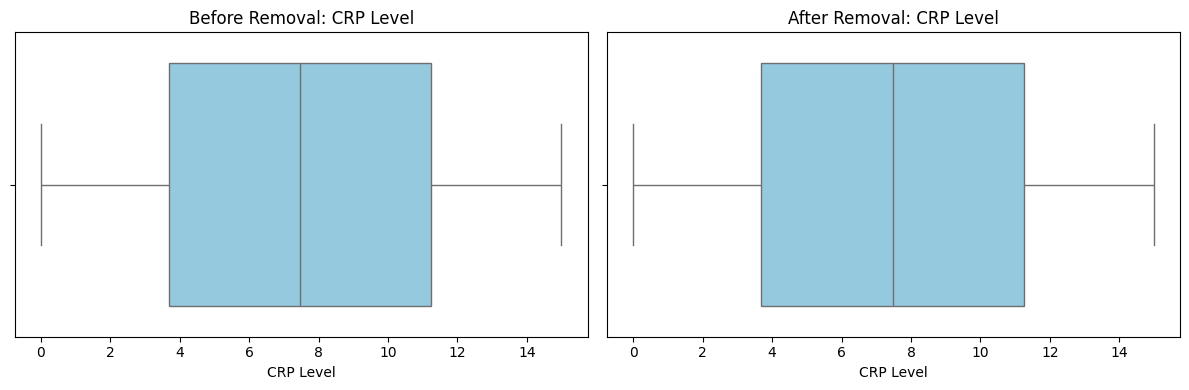

Homocysteine Level: 0 outliers detected


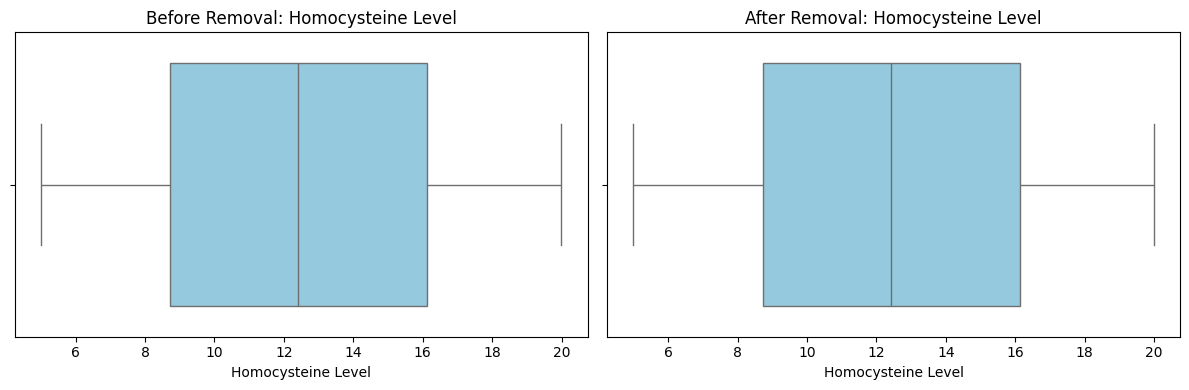

In [ ]:
# Numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
continuous_cols = [col for col in numeric_cols if df[col].nunique() > 3]


outlier_remover = OutlierRemover(columns=continuous_cols)
df_clean = outlier_remover.fit_transform(df)

# Optional: plot boxplots for each numeric column before/after removal
def plot_outliers(original, cleaned, columns):
    for col in columns:
        Q1 = original[col].quantile(0.25)
        Q3 = original[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5*IQR
        upper = Q3 + 1.5*IQR
        outliers = original[(original[col] < lower) | (original[col] > upper)]
        print(f"{col}: {len(outliers)} outliers detected")

        fig, axes = plt.subplots(1,2, figsize=(12,4))
        sns.boxplot(x=original[col], ax=axes[0], color='skyblue')
        axes[0].set_title(f"Before Removal: {col}")
        sns.boxplot(x=cleaned[col], ax=axes[1], color='skyblue')
        axes[1].set_title(f"After Removal: {col}")
        plt.tight_layout()
        plt.show()

plot_outliers(df, df_clean, continuous_cols)


# **Remove Duplicate values**

In [ ]:
class DuplicateRemover(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop_duplicates().reset_index(drop=True)

Number of duplicate rows: 1


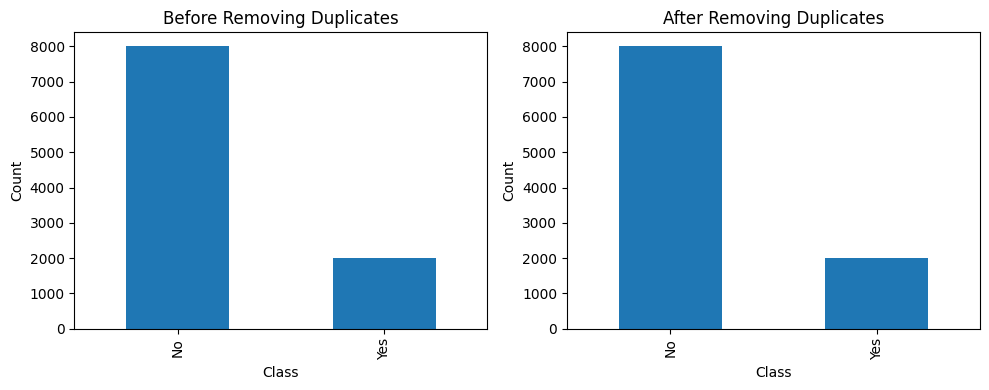

Dataset shape after removing duplicates: (9999, 21)


In [ ]:
print(f"Number of duplicate rows: {df.duplicated().sum()}")

# Plot before duplicate remove
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
df_clean['Heart Disease Status'].value_counts().plot(kind='bar', title="Before Removing Duplicates")
plt.xlabel("Class")
plt.ylabel("Count")

dup_remover = DuplicateRemover()
df = dup_remover.fit_transform(df_clean)

# Plot after duplicate remove
plt.subplot(1, 2, 2)
df['Heart Disease Status'].value_counts().plot(kind='bar', title="After Removing Duplicates")
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

print(f"Dataset shape after removing duplicates: {df.shape}")

# **Handle Class Imbalance**

In [ ]:
class ClassBalancer(BaseEstimator, TransformerMixin):
    def __init__(self, target_col):
        self.target_col = target_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        counts = X[self.target_col].value_counts()
        major_class = counts.idxmax()
        minor_class = counts.idxmin()
        df_major = X[X[self.target_col] == major_class]
        df_minor = X[X[self.target_col] == minor_class]
        df_minor_over = df_minor.sample(len(df_major), replace=True, random_state=42)
        balanced = pd.concat([df_major, df_minor_over], axis=0)
        return shuffle(balanced, random_state=42).reset_index(drop=True)

In [ ]:
print("Class distribution before balancing:")
print(df['Heart Disease Status'].value_counts())

balancer = ClassBalancer(target_col="Heart Disease Status")
df_balanced = balancer.fit_transform(df)

print("\nClass distribution after balancing:")
print(df_balanced['Heart Disease Status'].value_counts())

Class distribution before balancing:
Heart Disease Status
No     7999
Yes    2000
Name: count, dtype: int64

Class distribution after balancing:
Heart Disease Status
Yes    7999
No     7999
Name: count, dtype: int64


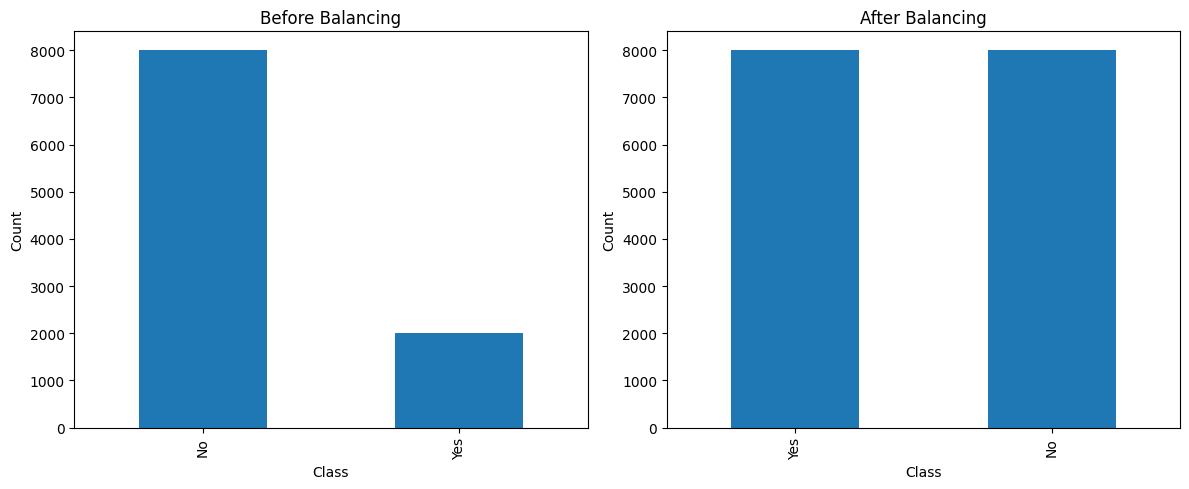

In [ ]:
# Fixed Plot Section
plt.figure(figsize=(12, 5))

# Before balancing
plt.subplot(1, 2, 1)
df['Heart Disease Status'].value_counts().plot(kind='bar')
plt.title("Before Balancing")
plt.xlabel("Class")
plt.ylabel("Count")

# After balancing
plt.subplot(1, 2, 2)
df_balanced['Heart Disease Status'].value_counts().plot(kind='bar')
plt.title("After Balancing")
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# **Scalling**

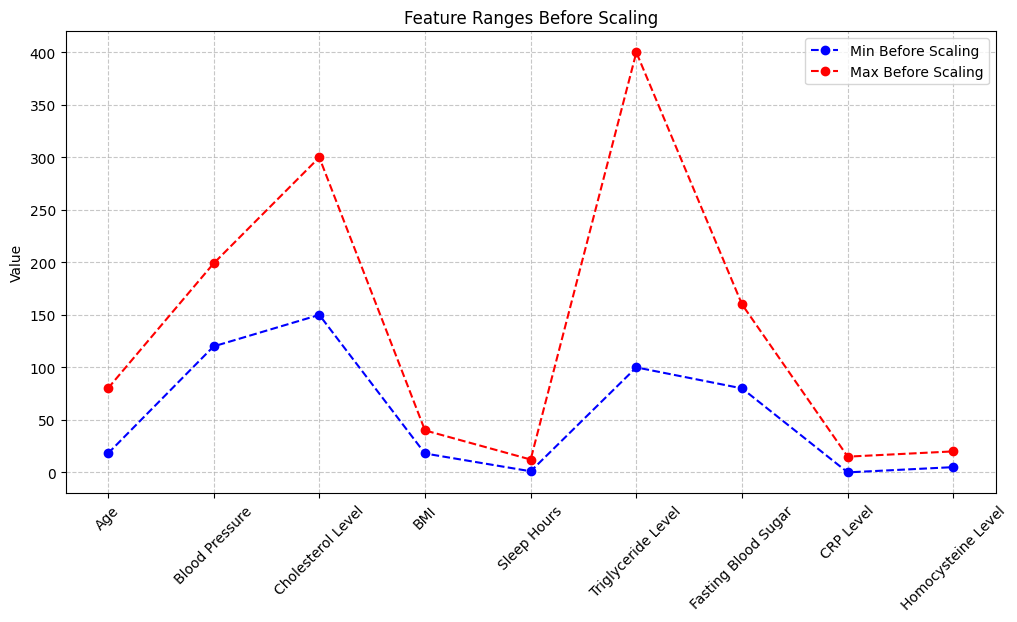

Applying Min-Max Scaling


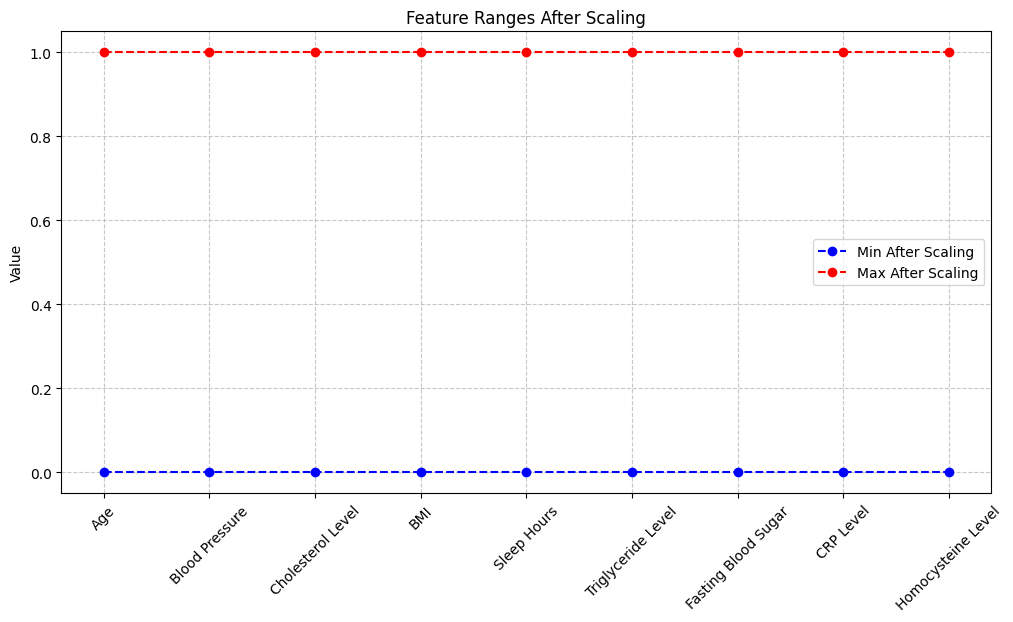

In [ ]:
continuous_cols = [col for col in numerical_cols if df[col].nunique() > 2]

# Detect outliers using IQR
outliers_exist = False
for col in continuous_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    if ((df[col] < lower) | (df[col] > upper)).any():
        outliers_exist = True
        print(f"Outliers detected in column: {col}")

# Plot min/max before scaling
min_before = df[continuous_cols].min()
max_before = df[continuous_cols].max()

plt.figure(figsize=(12,6))
plt.plot(continuous_cols, min_before.values, marker='o', linestyle='--', color='blue', label='Min Before Scaling')
plt.plot(continuous_cols, max_before.values, marker='o', linestyle='--', color='red', label='Max Before Scaling')
plt.xticks(rotation=45)
plt.title("Feature Ranges Before Scaling")
plt.ylabel("Value")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Apply scaling
if not outliers_exist:
    print("Applying Min-Max Scaling")
    scaler = MinMaxScaler()
else:
    print("Applying Standardization Scaling")
    scaler = StandardScaler()

df[continuous_cols] = scaler.fit_transform(df[continuous_cols])

# Plot min/max after scaling
min_after = df[continuous_cols].min()
max_after = df[continuous_cols].max()

plt.figure(figsize=(12,6))
plt.plot(continuous_cols, min_after.values, marker='o', linestyle='--', color='blue', label='Min After Scaling')
plt.plot(continuous_cols, max_after.values, marker='o', linestyle='--', color='red', label='Max After Scaling')
plt.xticks(rotation=45)
plt.title("Feature Ranges After Scaling")
plt.ylabel("Value")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

Encoding

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

binary_cols = [
    "Smoking", "Diabetes", "Family Heart Disease",
    "High Blood Pressure", "Low HDL Cholesterol", "High LDL Cholesterol"
]

ordinal_cols = [
    "Exercise Habits", "Stress Level", "Sugar Consumption"
]

ordinal_categories = [
    ["Low","Medium","High"],
    ["Low","Medium","High"],
    ["Low","Medium","High"]
]

nominal_cols = ["Gender"]

numeric_cols = [
    "Age","Blood Pressure","BMI","Triglyceride Level",
    "Fasting Blood Sugar","CRP Level","Homocysteine Level",
    "Sleep Hours","Cholesterol Level"
]



preprocessor = ColumnTransformer(
    transformers=[
        ("binary", OneHotEncoder(drop='if_binary'), binary_cols),
        ("ordinal", OrdinalEncoder(categories=ordinal_categories), ordinal_cols),
        ("nominal", OneHotEncoder(drop='first'), nominal_cols),
        ("numeric", scaler, numeric_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)


In [ ]:
X = df.drop(columns=["Heart Disease Status"])
y = df["Heart Disease Status"]

X_encoded = preprocessor.fit_transform(X)

if not isinstance(X_encoded, np.ndarray):
    X_encoded = X_encoded.toarray()

# Build encoded DataFrame
feature_names = preprocessor.get_feature_names_out()
df_encoded = pd.DataFrame(X_encoded, columns=feature_names)

# Add target back
df_encoded["Heart Disease Status"] = y.values


=== Before Encoding (Combined Figure) ===



/tmp/ipython-input-3589883005.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='Set2', ax=axes[i])
/tmp/ipython-input-3589883005.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='Set2', ax=axes[i])
/tmp/ipython-input-3589883005.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='Set2', ax=axes[i])
/tmp/ipython-input-3589883005.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` 

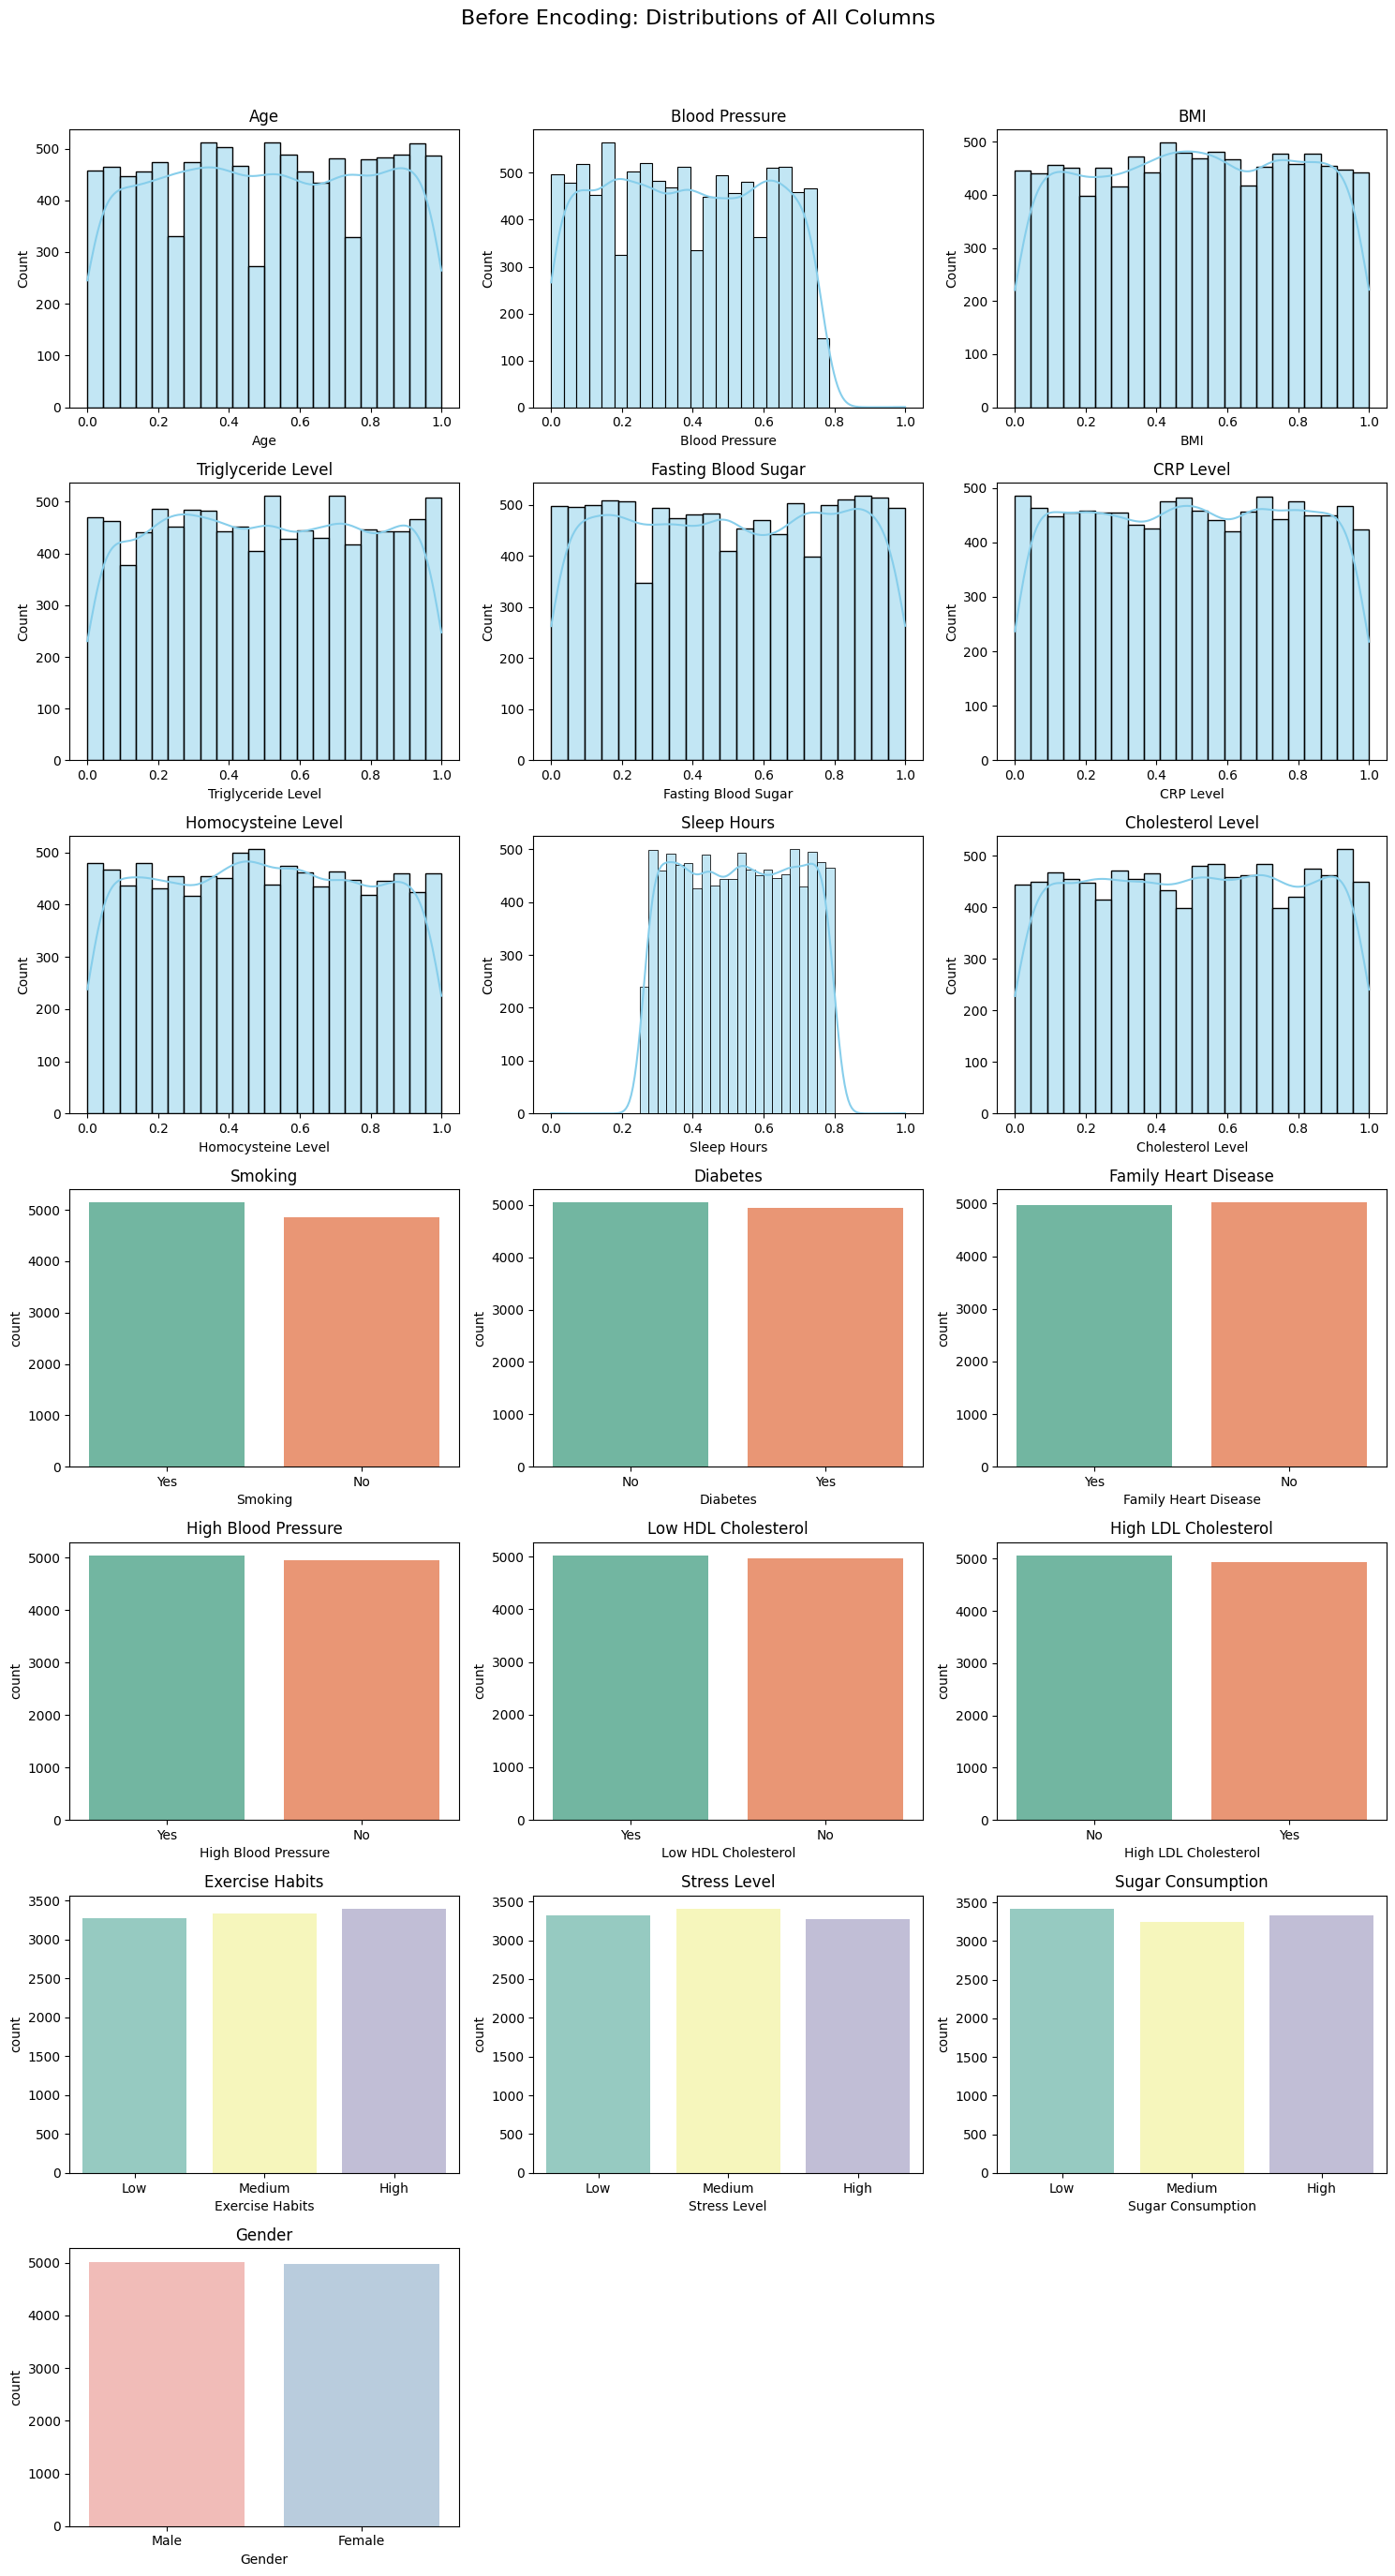

=== After Encoding ===



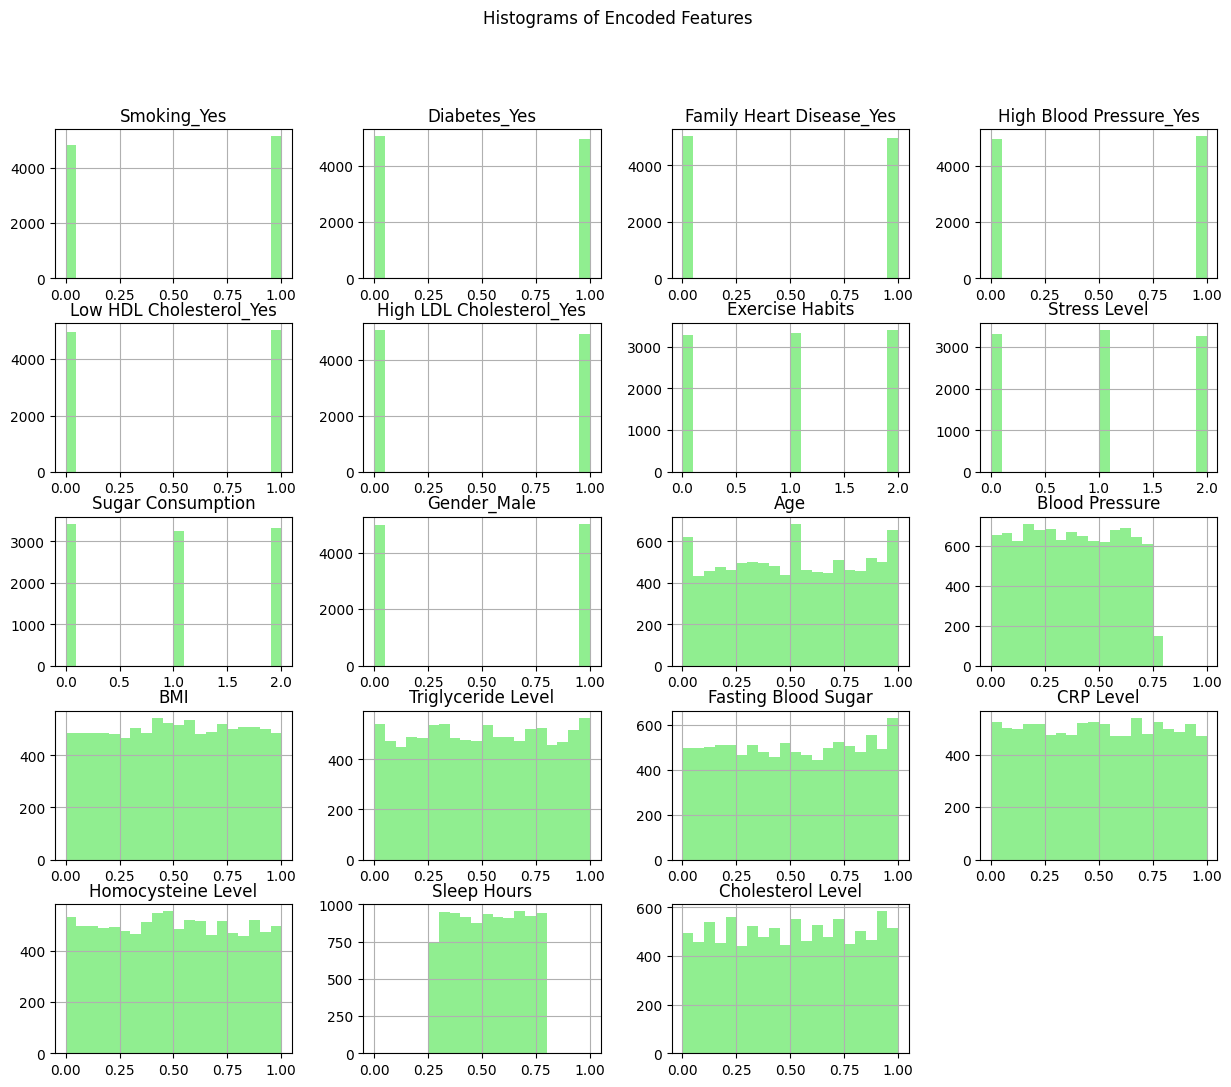

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

# Before Encoding: plot distributions
def plot_before_encoding(df, numeric_cols, binary_cols, ordinal_cols, nominal_cols):
    print("=== Before Encoding (Combined Figure) ===\n")

    all_cols = numeric_cols + binary_cols + ordinal_cols + nominal_cols
    n_cols = 3
    n_rows = (len(all_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
    axes = axes.flatten()

    for i, col in enumerate(all_cols):
        if col in numeric_cols:
            sns.histplot(df[col], kde=True, color='skyblue', ax=axes[i])
        elif col in binary_cols:
            sns.countplot(x=df[col], palette='Set2', ax=axes[i])
        elif col in ordinal_cols:
            sns.countplot(x=df[col], palette='Set3', order=["Low","Medium","High"], ax=axes[i])
        elif col in nominal_cols:
            sns.countplot(x=df[col], palette='Pastel1', ax=axes[i])
        axes[i].set_title(col)

    # Remove empty axes
    for j in range(len(all_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle("Before Encoding: Distributions of All Columns", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# After Encoding: plot heatmap and numeric distributions
def plot_after_encoding(X_encoded_df):
    print("=== After Encoding ===\n")

    # Histograms of numeric columns
    X_encoded_df.hist(figsize=(15,12), bins=20, color='lightgreen')
    plt.suptitle("Histograms of Encoded Features")
    plt.show()


plot_before_encoding(df, numeric_cols, binary_cols, ordinal_cols, nominal_cols)

X_encoded_df = pd.DataFrame(preprocessor.fit_transform(df), columns=preprocessor.get_feature_names_out())
plot_after_encoding(X_encoded_df)


In [ ]:
joblib.dump(preprocessor, "preprocessor.pkl")
print("Preprocessing complete and saved to preprocessor.pkl")


Preprocessing complete and saved to preprocessor.pkl


# **Split Train/Test**



In [ ]:
from sklearn.utils import shuffle

df_balanced = shuffle(df_balanced, random_state=42).reset_index(drop=True)

X = df_balanced.drop(columns=['Heart Disease Status'])
y = df_balanced['Heart Disease Status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
X_train.to_csv(os.path.join(DATA_PROCESSED, "X_train.csv"), index=False)
y_train.to_csv(os.path.join(DATA_PROCESSED, "y_train.csv"), index=False)
X_test.to_csv(os.path.join(DATA_PROCESSED, "X_test.csv"), index=False)
y_test.to_csv(os.path.join(DATA_PROCESSED, "y_test.csv"), index=False)

print("Train/Test split complete.")

Train/Test split complete.


# **KNN Training Pipeline**

In [ ]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


In [ ]:
# Load raw train/test sets
X_train_raw = pd.read_csv(os.path.join(DATA_PROCESSED, "X_train.csv"))
y_train = pd.read_csv(os.path.join(DATA_PROCESSED, "y_train.csv")).squeeze()
X_test_raw = pd.read_csv(os.path.join(DATA_PROCESSED, "X_test.csv"))
y_test = pd.read_csv(os.path.join(DATA_PROCESSED, "y_test.csv")).squeeze()

# Load the preprocessor
preprocessor = joblib.load("preprocessor.pkl")

# Transform X_train and X_test using the loaded preprocessor
X_train = preprocessor.transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

# Convert transformed arrays back to DataFrames for consistency and potential inspection
# Get feature names from the preprocessor to name the columns
feature_names = preprocessor.get_feature_names_out()
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('knn', KNeighborsClassifier())
])
knn_pipeline.fit(X_train_raw, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Smoking', 'Diabetes',
                                                   'Family Heart Disease',
                                                   'High Blood Pressure',
                                                   'Low HDL Cholesterol',
                                                   'High LDL Cholesterol']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['Low',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Low',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Low',
                                                                              'Medium',
                                                                              'High']]),
                                                  ['Exercise Habits',
                                                   'Stress Level',
                                                   'Sugar Consumption']),
                                                 ('nominal',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gender']),
                                                 ('numeric', MinMaxScaler(),
                                                  ['Age', 'Blood Pressure',
                                                   'BMI', 'Triglyceride Level',
                                                   'Fasting Blood Sugar',
                                                   'CRP Level',
                                                   'Homocysteine Level',
                                                   'Sleep Hours',
                                                   'Cholesterol Level'])],
                                   verbose_feature_names_out=False)),
                ('knn', KNeighborsClassifier())])

# **Predictions & Evaluation**

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Predictions & Evaluation
y_pred = knn_pipeline.predict(X_test_raw)  # FIXED

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("\nKNN MODEL RESULTS")
print("="*40)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"\nConfusion Matrix:\n{conf_matrix}")
print(f"\nClassification Report:\n{class_report}")

# Correct CV
cv_scores = cross_val_score(knn_pipeline, X_train_raw, y_train, cv=5, scoring='accuracy')

print("CV Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())



KNN MODEL RESULTS
Accuracy: 0.6919
Precision: 0.7067
Recall: 0.6919
F1-Score: 0.6863

Confusion Matrix:
[[ 893  707]
 [ 279 1321]]

Classification Report:
              precision    recall  f1-score   support

          No       0.76      0.56      0.64      1600
         Yes       0.65      0.83      0.73      1600

    accuracy                           0.69      3200
   macro avg       0.71      0.69      0.69      3200
weighted avg       0.71      0.69      0.69      3200

CV Scores: [0.66328125 0.66601562 0.65859375 0.68307933 0.66393122]
Mean CV Accuracy: 0.6669802351992966


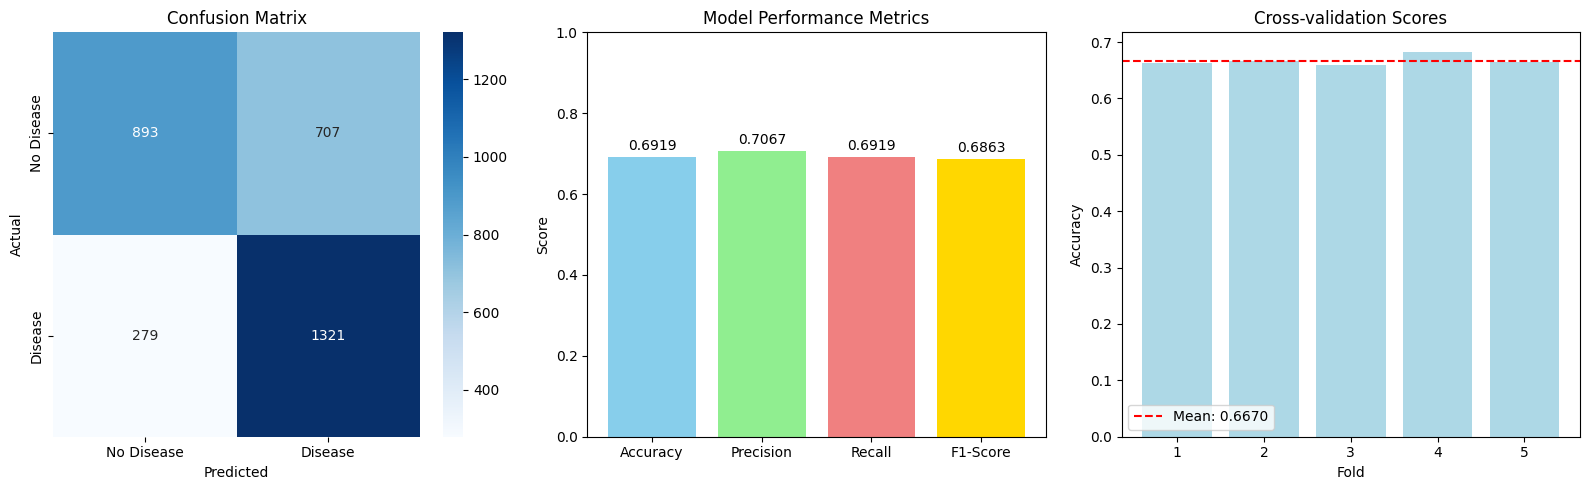

In [ ]:
# Enhanced visualization
plt.figure(figsize=(16, 5))

# 1. Confusion Matrix Heatmap
plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 2. Metrics Visualization
plt.subplot(1, 3, 2)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
scores = [accuracy, precision, recall, f1]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']

bars = plt.bar(metrics, scores, color=colors)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)

# Add value labels on bars
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.4f}', ha='center', va='bottom')

# 3. Cross-validation Scores
plt.subplot(1, 3, 3)
plt.bar(range(1, 6), cv_scores, color='lightblue')
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.title('Cross-validation Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save the trained KNN model
joblib.dump(knn_pipeline, os.path.join(DATA_PROCESSED, 'knn_heart_disease_model.pkl'))
print("Trained KNN model saved!")

Trained KNN model saved!


# **Knn hyperparameter tunning with gridsearchcv**

In [ ]:
print("\n" + "="*60)
print("HYPERPARAMETER TUNING FOR KNN")
print("="*60)

param_grid = {
    'n_neighbors': [3,5,7,9,11,13,15,17],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1,2]
}

grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid.fit(X_train, y_train)
best_knn = grid.best_estimator_

print("\nGRID SEARCH COMPLETED")
print("="*60)
print(f"Best Parameters: {grid.best_params_}")
print(f"Best CV Accuracy: {grid.best_score_:.4f}")


# Evaluate Tuned Model
y_pred_tuned = best_knn.predict(X_test)

tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
tuned_precision = precision_score(y_test, y_pred_tuned, average='weighted')
tuned_recall = recall_score(y_test, y_pred_tuned, average='weighted')
tuned_f1 = f1_score(y_test, y_pred_tuned, average='weighted')

tuned_conf_matrix = confusion_matrix(y_test, y_pred_tuned)

print("\n" + "="*60)
print("TUNED KNN MODEL RESULTS")
print("="*60)
print(f"Accuracy:  {tuned_accuracy:.4f}")
print(f"Precision: {tuned_precision:.4f}")
print(f"Recall:    {tuned_recall:.4f}")
print(f"F1 Score:  {tuned_f1:.4f}")
print("\nConfusion Matrix:")
print(tuned_conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned))




HYPERPARAMETER TUNING FOR KNN
Fitting 5 folds for each of 96 candidates, totalling 480 fits

GRID SEARCH COMPLETED
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best CV Accuracy: 0.7786

TUNED KNN MODEL RESULTS
Accuracy:  0.8137
Precision: 0.8524
Recall:    0.8137
F1 Score:  0.8085

Confusion Matrix:
[[1037  563]
 [  33 1567]]

Classification Report:
              precision    recall  f1-score   support

          No       0.97      0.65      0.78      1600
         Yes       0.74      0.98      0.84      1600

    accuracy                           0.81      3200
   macro avg       0.85      0.81      0.81      3200
weighted avg       0.85      0.81      0.81      3200



**Compare Default vs Tuned**


DEFAULT VS TUNED KNN COMPARISON
Metric       Default      Tuned        Improvement
-------------------------------------------------------
Accuracy    0.6919     0.8137     +0.1219
Precision   0.7067     0.8524     +0.1458
Recall      0.6919     0.8137     +0.1219
F1-Score    0.6863     0.8085     +0.1222


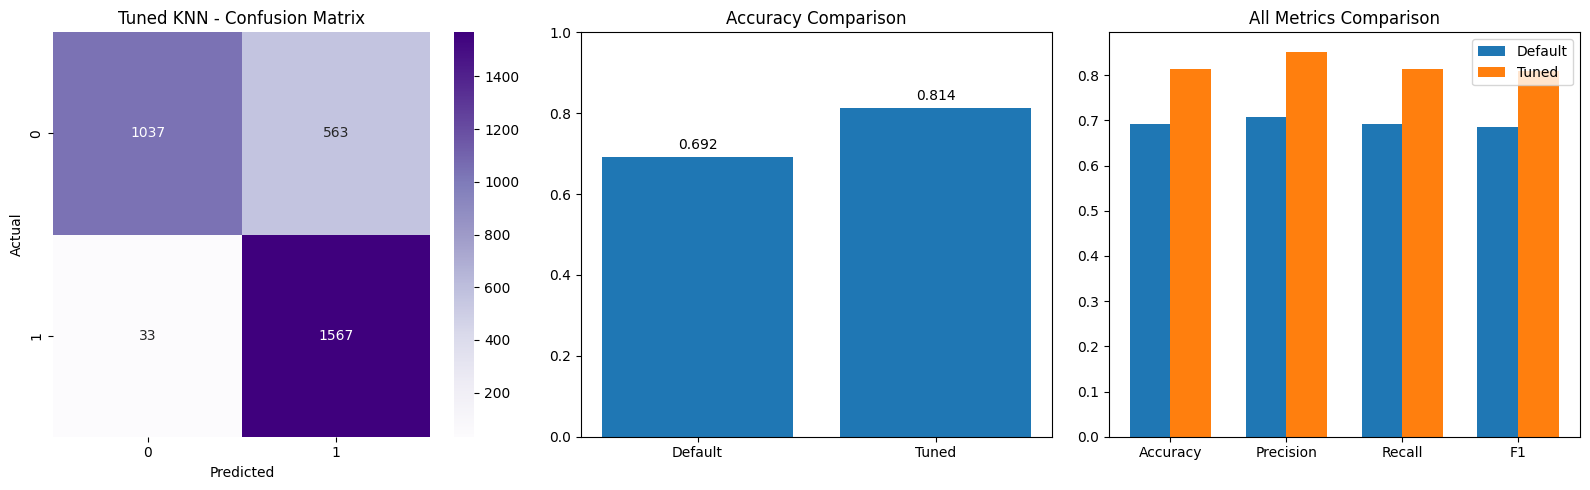

In [ ]:
print("\n" + "="*60)
print("DEFAULT VS TUNED KNN COMPARISON")
print("="*60)

y_pred_default = knn_pipeline.predict(X_test_raw)

default_accuracy = accuracy_score(y_test, y_pred_default)
default_precision = precision_score(y_test, y_pred_default, average='weighted')
default_recall = recall_score(y_test, y_pred_default, average='weighted')
default_f1 = f1_score(y_test, y_pred_default, average='weighted')

print(f"{'Metric':<12} {'Default':<12} {'Tuned':<12} {'Improvement'}")
print("-"*55)
print(f"Accuracy    {default_accuracy:.4f}     {tuned_accuracy:.4f}     {tuned_accuracy-default_accuracy:+.4f}")
print(f"Precision   {default_precision:.4f}     {tuned_precision:.4f}     {tuned_precision-default_precision:+.4f}")
print(f"Recall      {default_recall:.4f}     {tuned_recall:.4f}     {tuned_recall-default_recall:+.4f}")
print(f"F1-Score    {default_f1:.4f}     {tuned_f1:.4f}     {tuned_f1-default_f1:+.4f}")


# Visualization
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.heatmap(tuned_conf_matrix, annot=True, fmt='d', cmap='Purples')
plt.title("Tuned KNN - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1,3,2)
plt.bar(["Default","Tuned"], [default_accuracy, tuned_accuracy])
plt.title("Accuracy Comparison")
plt.ylim(0,1)
for i,val in enumerate([default_accuracy, tuned_accuracy]):
    plt.text(i, val+0.02, f"{val:.3f}", ha="center")

plt.subplot(1,3,3)
labels = ['Accuracy','Precision','Recall','F1']
default_scores = [default_accuracy, default_precision, default_recall, default_f1]
tuned_scores = [tuned_accuracy, tuned_precision, tuned_recall, tuned_f1]

x = np.arange(len(labels))
w = 0.35

plt.bar(x-w/2, default_scores, w, label="Default")
plt.bar(x+w/2, tuned_scores, w, label="Tuned")
plt.xticks(x, labels)
plt.title("All Metrics Comparison")
plt.legend()

plt.tight_layout()
plt.show()

# **Save Model**

In [ ]:
import joblib
joblib.dump(DATA_PROCESSED, "knn_tuned_model.pkl")
print("\nTuned model saved as knn_tuned_model.pkl")


Tuned model saved as knn_tuned_model.pkl
